In [18]:
import copy
import logging
import models
import numpy as np
import pandas as pd
import os
import importlib
from collections import Counter
from datetime import datetime
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_score, recall_score, roc_auc_score, f1_score
from sqlalchemy import create_engine, inspect

logging.basicConfig(level=logging.INFO)

PSQL = 'postgres://{}@localhost:5432/rpred'


## [Data](#data)
## [Baseline](#baseline)
## [Apply Models](#models)

1. Load data from data/model_input.
2. Determine if data needs to be further truncated for test run.
3. Create grid search with algorithm and parameters. 
4. Split data into train and test set.
5. Train grid search on train set.
6. Get ROC curve data with test set.
7. Create dataframe of scores and model itself.
8. Pickle models as dataframes.
9. Save results dataframe as CSV.
10. Save symlink to feature/target data. 

# Functions

In [194]:
# Returns: (false positive, true positive), results dictionary, model itself
# Some metrics may be None.
def apply_model(model, data, target):
    # Instantiate grid search
    grid = GridSearchCV(estimator=model['classifier'],
                        param_grid=model['params'],
                       verbose=1)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X_train = pd.DataFrame(data=X_train, columns=data.columns)

    logging.info("Fitting on train data ({} rows)".format(len(X_train)))
    # Train grid search
    grid.fit(X_train, y_train)
    
    logging.info("Scored " + str(grid.best_score_) + " with " + str(grid.best_params_))
    logging.info("Used scorer " + str(grid.scorer_))
    # Get probabilities on test set for ROC plotting
    fpr = None
    tpr = None
    try:
        y_pred_proba = grid.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    except Exception as e:
        logging.info(e)
    
    # Scores
    results_dict = {}
    try:
        y_pred = grid.predict(X_test)
        results_dict['classification_report'] = classification_report(y_test, y_pred)
        results_dict['accuracy'] = accuracy_score(y_test, y_pred)
        results_dict['precision'] = precision_score(y_test, y_pred)
        results_dict['recall'] = recall_score(y_test, y_pred)
        results_dict['f1'] = f1_score(y_test, y_pred)
        results_dict['roc_auc'] = roc_auc_score(y_test, y_pred)
    except Exception as e:
        logging.info(e)
    
    results_dict['train_class_balance'] = class_ratio(y_train)
    results_dict['test_class_balance'] = class_ratio(y_test)
    for p in grid.best_params_:
        results_dict[p] = grid.best_params_[p]
    return (fpr, tpr), results_dict, grid

def class_ratio(y):
    return ', '.join(["{}: {}".format(c[0], '{:.2%}'.format(c[1]/len(y))) for c in Counter(y).items()])

def load_data(timestamp, now=None):
    PATH = "../data/model_input/{}/{}"

    X = pd.read_csv(PATH.format(timestamp, "features"))
    X = X[X.columns[1:]]
    y = pd.read_csv(PATH.format(timestamp, "target"))['target']
        
    # Save data if given path
    if now:
        os.symlink("../../data/model_input/{}".format(timestamp), "../output/{}/data".format(now))
    
    return X, y

def make_baseline(X):
    return np.where(X['stars'] > 1.5, 0, 1) 

<a class="anchor" id="data"></a>

# Load data

In [203]:
test_run = False
now = datetime.now().strftime("%Y%m%d%H%M%S%f")
now = "FINAL_normal"

if test_run:
    now = "test_"+now
os.mkdir("../output/{}".format(now))

#X, y = load_data("total_hrs", now)
X, y = load_data("20180810_bal_normal", now)

 <a class="anchor" id="baseline"></a>

# Create Baseline Prediction (predict closure if stars < 2)

In [205]:
y_pred_base = make_baseline(X)
y_pred_base

array([0, 0, 0, ..., 0, 0, 0])

 <a class="anchor" id="models"></a>
# Run Models

In [206]:
importlib.reload(models)

results = pd.DataFrame()

roc_data_dict = {}
for model_name, model in models.get_models().items():
    X0 = copy.deepcopy(X)
    y0 = copy.deepcopy(y)
    logging.info("Training " + model_name)
        
    if test_run:
        test_run_size = int(len(X)*model['test_run_size'])
        X0 = X[:test_run_size]
        y0 = y[:test_run_size]
        logging.info("Test run, so reduce rows to {}".format(len(X0)))
        
    if model_name == 'XGBoost':
        model['params']['feature_names'] = X0.columns
    roc_data, scores, est = apply_model(model, X0, y0)
    
    # Save results
    scores['model'] = model_name
    scores['est'] = copy.deepcopy(est)
    roc_data_dict[model_name] = roc_data
    results = results.append(scores, ignore_index=True)
    results.to_csv("../output/{}/result".format(now))
    
    # Pickle trained model
    results[results['model'] == model_name][['model', 'est']].to_pickle("../output/{}/{}.pkl".format(now, model_name))
    
results.head()

INFO:root:Training gradient_boosting
INFO:root:Fitting on train data (27270 rows)


Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 19.7min finished
INFO:root:Scored 0.8866153281994866 with {'learning_rate': 0.7, 'max_depth': 8, 'max_features': None, 'min_impurity_decrease': 0.01, 'min_samples_leaf': 0.05, 'min_weight_fraction_leaf': 0, 'n_estimators': 215}
INFO:root:Used scorer <function _passthrough_scorer at 0x7ffb1ccdeea0>
INFO:root:Training xgb_tree
INFO:root:Fitting on train data (27270 rows)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

,accuracy,classification_report,est,f1,learning_rate,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_weight_fraction_leaf,model,n_estimators,precision,recall,roc_auc,test_class_balance,train_class_balance,booster
0,0.888009,precision recall f1-score s...,"GridSearchCV(cv=None, error_score='raise',\n ...",0.893448,0.7,8.0,None,0.01,0.05,0.0,gradient_boosting,215.0,0.844480,0.948444,0.888601,"0: 50.50%, 1: 49.50%","0: 49.83%, 1: 50.17%",NaN
1,0.931133,precision recall f1-score s...,"GridSearchCV(cv=None, error_score='raise',\n ...",0.934560,0.2,9.0,NaN,NaN,NaN,NaN,xgb_tree,200.0,0.894895,0.977904,0.930864,"0: 49.71%, 1: 50.29%","1: 49.90%, 0: 50.10%",gbtree


In [183]:
met = results[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
print(met.loc[0][1:])
print(met.loc[1][1:])

#baseline_metrics = [f(y, y_pred_base) for f in 
#                    [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]]
    
#print(baseline_metrics)

accuracy     0.888449
precision    0.853531
recall       0.937417
f1            0.89351
roc_auc      0.888524
Name: 0, dtype: object
accuracy     0.929593
precision    0.893023
recall        0.97548
f1           0.932432
roc_auc      0.929774
Name: 1, dtype: object


In [174]:
fpr_base, tpr_base, _ = roc_curve(y, y_pred_base)
print(fpr_base)
print(tpr_base)

[0.         0.02480748 1.        ]
[0.         0.00489549 1.        ]


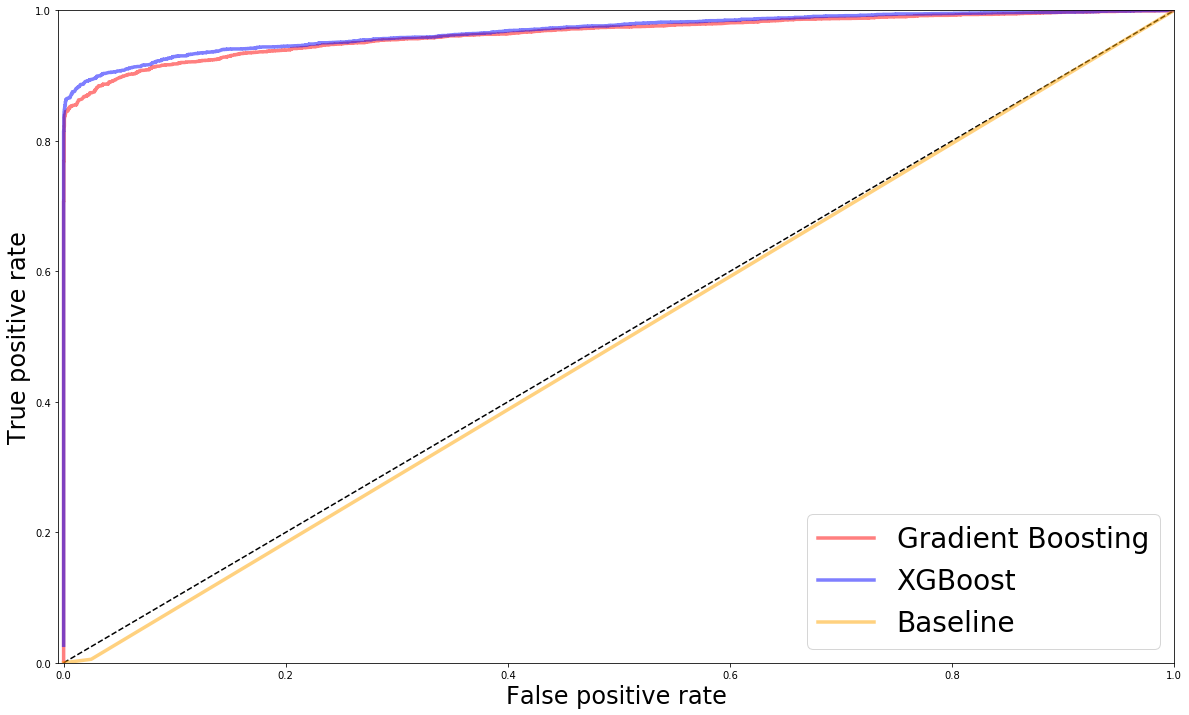

In [22]:
# This step really should be in the visualization script, but I was lazy. 

import matplotlib.pyplot as plt

%matplotlib inline

# Plot ROC
plt.figure(1, figsize=(20, 12))
plt.xlim(-0.005, 1)
plt.ylim(0, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(gb[0], gb[1], label='Gradient Boosting', alpha=0.5, linewidth=3.5, color='r')
plt.plot(xgb[0], xgb[1], label='XGBoost', alpha=0.5, linewidth=3.5, color='blue')
plt.plot(fpr_base, tpr_base, label='Baseline', alpha=0.5, linewidth=3.5, color='orange')
plt.xlabel('False positive rate', fontsize=24)
plt.ylabel('True positive rate', fontsize=24)
plt.legend(loc='best', fontsize = 28)
plt.show()

# More testing for trained models

In [208]:
gb = results[results['model'] == 'gradient_boosting']['est'].iloc[0]
xgb = results[results['model'] == 'xgb_tree']['est'].iloc[0]
print(gb.best_estimator_)
print(gb.param_grid)
print(xgb.best_estimator_)
print(xgb.param_grid)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.7, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.01, min_impurity_split=None,
              min_samples_leaf=0.05, min_samples_split=2,
              min_weight_fraction_leaf=0, n_estimators=215, presort='auto',
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
{'learning_rate': [0.6, 0.7], 'max_depth': [7, 8], 'max_features': [None], 'min_weight_fraction_leaf': [0, 0.01], 'min_impurity_decrease': [0, 0.01], 'min_samples_leaf': [0.05, 0.1], 'n_estimators': [200, 215]}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_la

In [209]:
def graph_metric(metric, annot, title):
    sizes = [1000, 5000, 10000, 12000, 19851]

    plt.figure(1, figsize=(20, 12))
    plt.title(title, fontsize=28)
    #plt.xlim(-0.005, 1)
    plt.ylim(0, 1)
    plt.plot(sizes, [p[0] for p in metric], label='Gradient Boosting', alpha=0.5, linewidth=3.5, color='r')
    plt.plot(sizes, [p[1] for p in metric], label='XGBoost', alpha=0.5, linewidth=3.5, color='blue')
    plt.plot(sizes, [p[2] for p in metric], label='Baseline', alpha=0.5, linewidth=3.5, color='orange')
    plt.xlabel('Sample Size', fontsize=24)
    plt.ylabel('Score', fontsize=24)
    plt.legend(loc='best', fontsize = 28)
    
    for i, txt in enumerate(annot):
        plt.annotate(txt, (sizes[i], metric[i][0]))
    
    plt.show()

Counter({1: 18180, 0: 1671})


/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/jessica/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

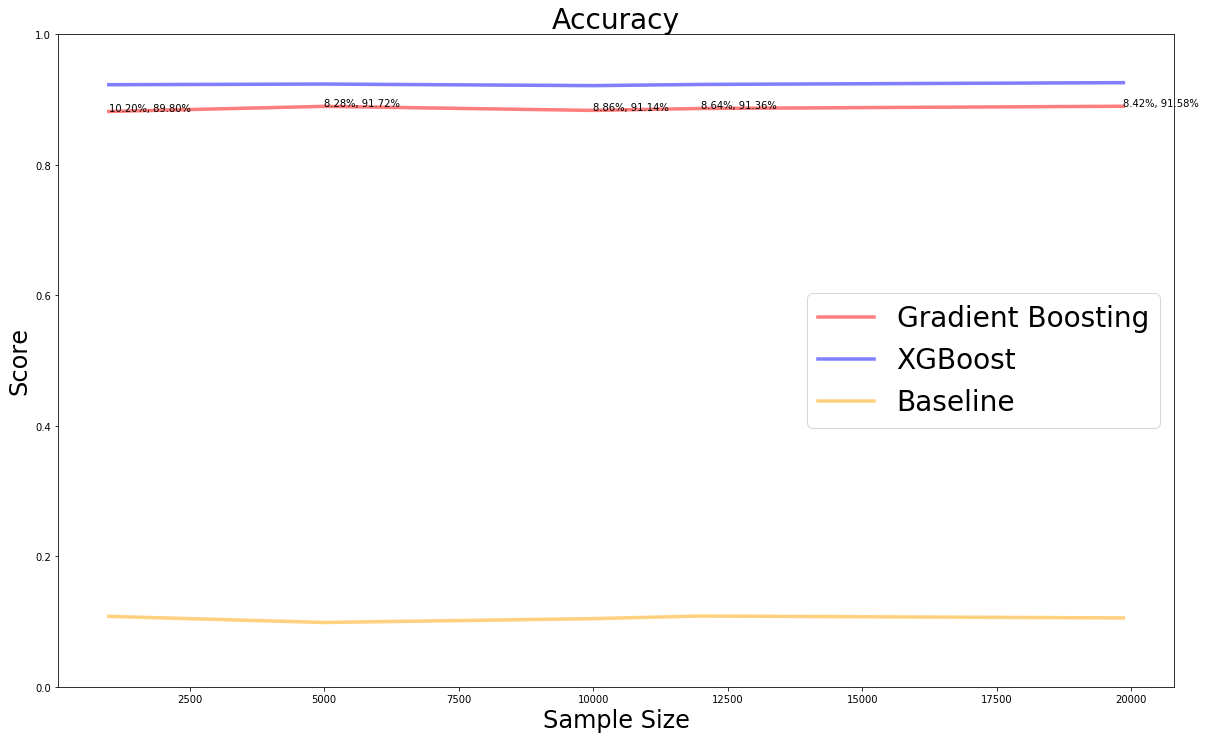

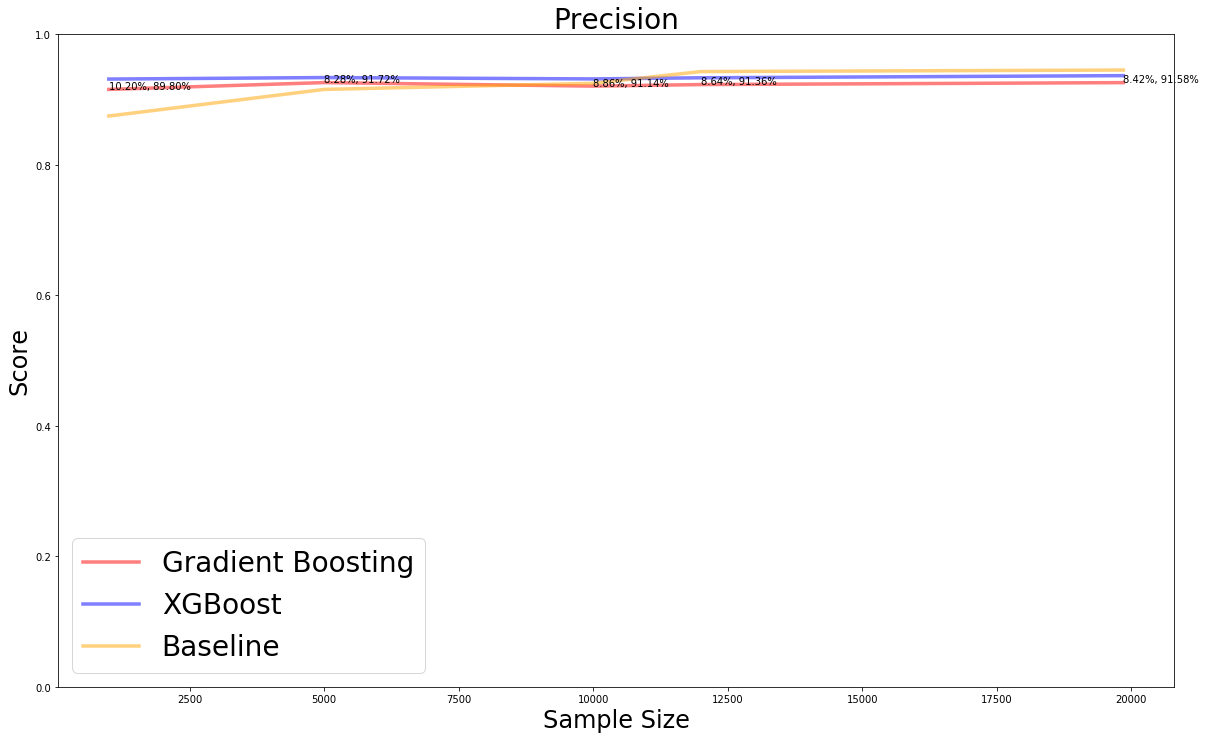

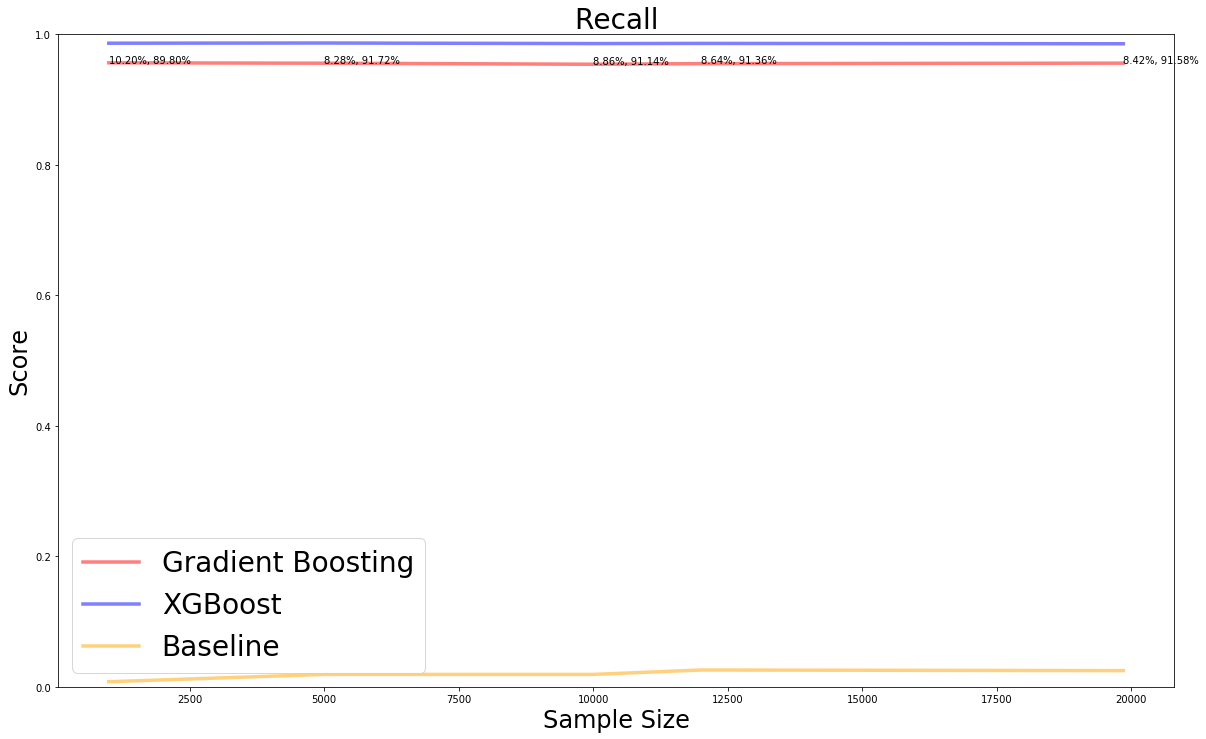

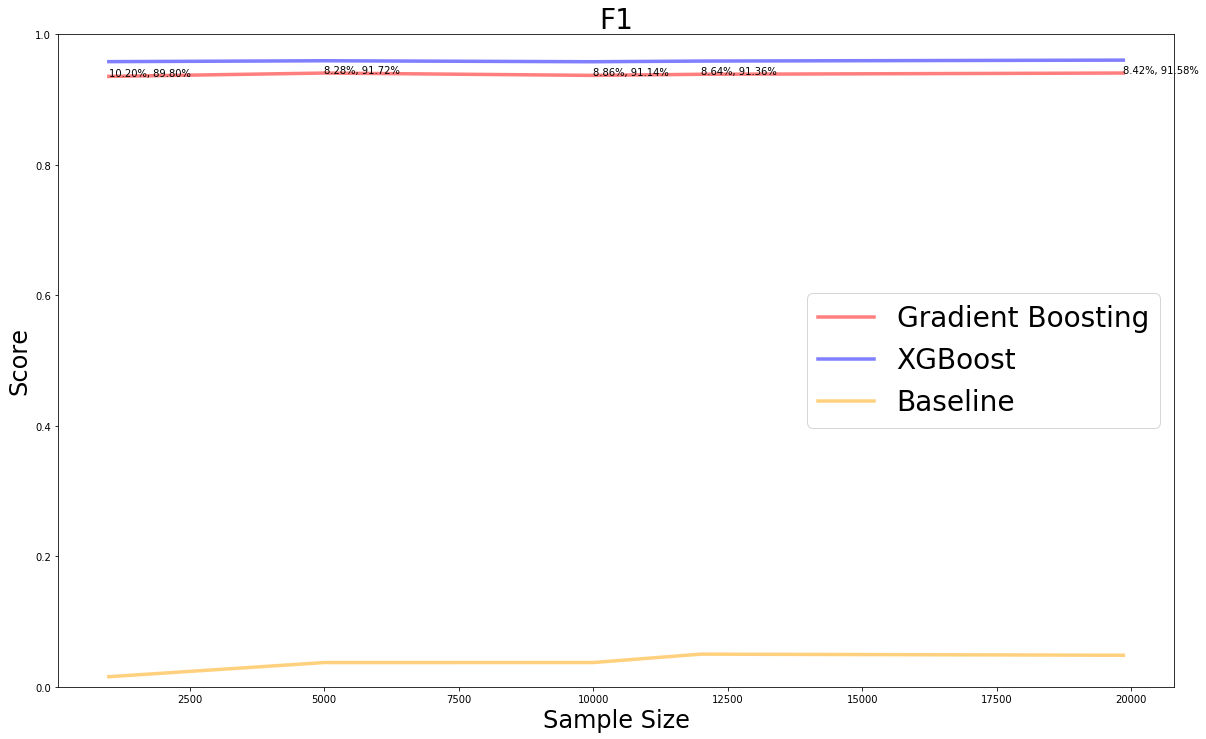

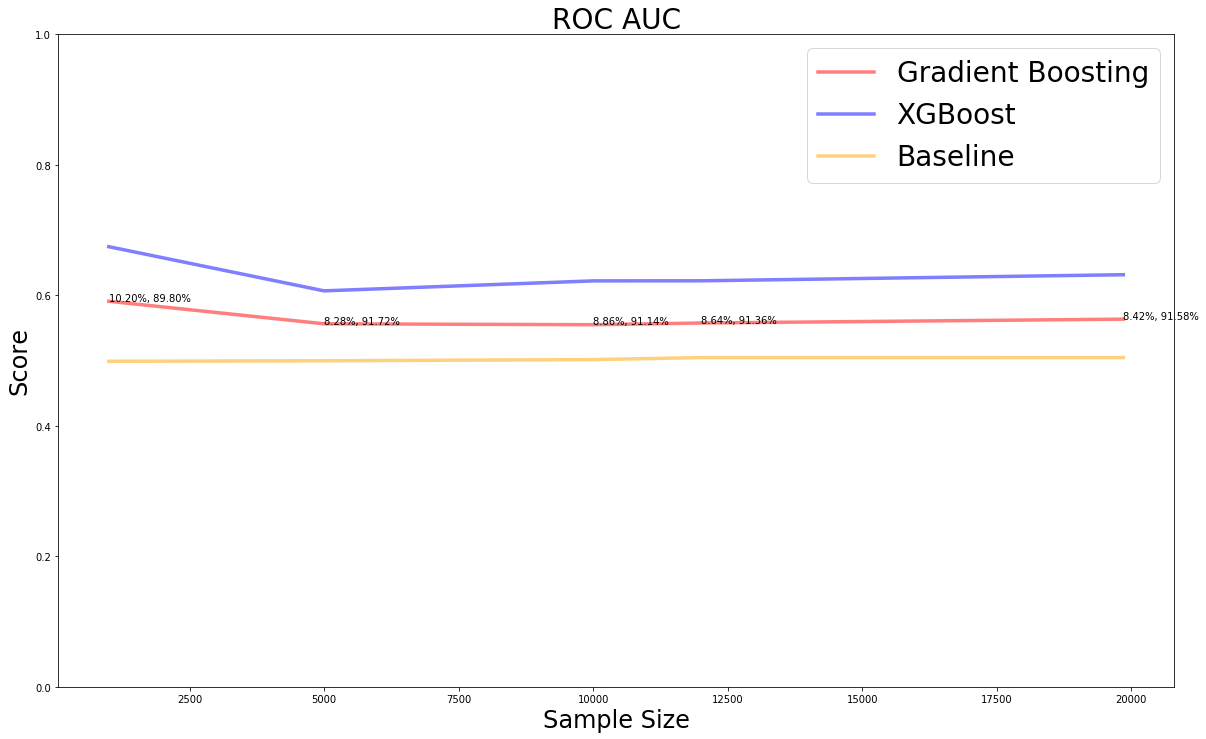

In [210]:
#Xt, yt = load_data("total_hrs")  # balanced with SMOTE
#Xt, yt = load_data("20180809_unbal")  # no SMOTE
Xt, yt = load_data("20180810_unbal_normal")  # no SMOTE, 1 = open
print(Counter(yt))

acc = []
prec = []
rec = []
f1 = []
roc_auc = []
annot = []
for l in [1000, 5000, 10000, 12000, 19851]:
    Xl = Xt[:l]
    yl = yt[:l]
    c = Counter(yl)
    annot.append('{:.2%}, {:.2%}'.format(c[0]/len(yl), c[1]/len(yl)))
    y_preds = [gb.predict(Xl), xgb.predict(Xl), make_baseline(Xl)]                 
    acc.append([accuracy_score(yl, y) for y in y_preds])
    prec.append([precision_score(yl, y) for y in y_preds])
    rec.append([recall_score(yl, y) for y in y_preds])
    f1.append([f1_score(yl, y) for y in y_preds])
    roc_auc.append([roc_auc_score(yl, y) for y in y_preds])
    
graph_metric(acc, annot, "Accuracy")
graph_metric(prec, annot, "Precision")
graph_metric(rec, annot, "Recall")
graph_metric(f1, annot, "F1")
graph_metric(roc_auc, annot, "ROC AUC")